In [83]:
# Imports
import matplotlib.pyplot as plt
import cv2
import glob
import os
import numpy as np
import math

# Make figure resolution higher
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [84]:
# Reading in images
def imread(file_name, intensities=None, normalize=False, flag=-1, scale=1.0):
    img_names = glob.glob(file_name) # Get all of a certain file type that matches file_name
    img_list = []
    if len(img_names) == 0:
        print("[No {} images]".format(file_name))
        exit()
    img_names = sorted(img_names)
    for i, path in enumerate(img_names):
        im = cv2.imread(path, flag)
        img = cv2.resize(im, None, fx=scale, fy=scale) # Read in image
        # Normalize if needed (in this case since it's images of the moon it's almost grayscale so it doesn't make much of a difference anyway)
        if np.any(intensities):
            img = img / intensities[i]
        elif normalize:
            img = img / 255.0
        img_list.append(img)
    return img_list

In [85]:
def create_light_directions(file_name):
    img_names = glob.glob(file_name) # Get all of a certain file type that matches file_name
    angle_str = lambda x: int(x.split("/")[-1].replace(".jpg", "").replace("p", "").replace("m", "-"))
    light_directions_file = open("./light_directions_synthetic.txt", "w")
    sin_deg = lambda x: math.sin(math.radians(x))
    cos_deg = lambda x: math.cos(math.radians(x))
    for name in img_names:
        print(name)
        light_directions_file.write(f"{sin_deg(angle_str(name))} 0 {cos_deg(angle_str(name))}\n")
    light_directions_file.close()

In [86]:
from numpy import loadtxt

dataPath = "test_data/"
object = []
for obj in (os.listdir(dataPath)):
    object.append(obj)

imgs = imread(f"./test_data_synthetic/*.jpg", intensities=None, normalize=False)
create_light_directions(f"./test_data_synthetic/*.jpg")
L_direction = loadtxt(f"./light_directions_synthetic.txt") # Load in the light directions

./test_data_synthetic/p10.jpg
./test_data_synthetic/m5.jpg
./test_data_synthetic/p15.jpg
./test_data_synthetic/m10.jpg
./test_data_synthetic/p5.jpg


In [87]:
imgs = np.array(imgs, dtype=np.uint8)

In [88]:
# Actual photometric stereo algorithm (kinda complicated but I think I get it)
# Uses pseudoinverse to solve for the surface normals and albedos
def photometric_stereo(imgs, L_list):
    """
    Perform photometric stereo using multiple images of an object captured under different light sources.

    Parameters
    ----------
    imgs: np.ndarray
        Numpy array containing all the images of the object taken with different light sources.
    L_list: list
        List of light source directions (vectors with 3 positional elements x, y, z) for each image.

    Returns
    -------
    img_normal: np.ndarray
        Computed surface normals of the object.
    img_albedo: np.ndarray
        Computed albedos (reflectance) of the object.
    img_normal_rgb: np.ndarray
        RGB representation of the surface normals for visualization.
    """

    # Convert L_list to a numpy array for easier manipulation
    L = np.array(L_list)
    # Transpose the array
    Lt = L.T

    # Get the height and width of the first image in the set
    h, w = imgs[0].shape[:2]

    # Initialize arrays for storing computed values
    img_normal = np.zeros((h, w, 3))
    img_albedo = np.zeros((h, w, 3))
    I = np.zeros((len(L_list), 3))
    normals = np.zeros((h, w, 3))
    I_gray = np.zeros(len(L_list))

    # Iterate over each pixel in the images
    for x in range(w):
        for y in range(h):
            # Collect intensity values for each image at the current pixel
            for i in range(len(imgs)):
                I[i] = imgs[i][y][x]
                # img_gray = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY)
                # I_gray[i] = img_gray[y][x]

            # Compute surface normals and albedos using photometric stereo equations
            tmp1 = np.linalg.pinv(np.dot(Lt, L)) # Psuedoinverse
            tmp2 = np.dot(Lt, I)
            N = np.dot(tmp1, tmp2).T
            # print(N)
            # N = np.dot(np.linalg.inv(np.dot(Lt, L)), np.dot(Lt, I)).T
            rho = np.linalg.norm(N, axis=1)
            img_albedo[y][x] = rho

            # Convert surface normals to grayscale and normalize
            N_gray = N[0] * 0.2989 + N[1] * 0.5870 + N[2] * 0.1140
            # print(N_gray)
            Nnorm = np.linalg.norm(N)
            if Nnorm == 0:
                continue
            img_normal[y][x] = N_gray / Nnorm
            # normals[y][x] = np.dot(np.linalg.inv(np.dot(Lt, L)), np.dot(Lt, I_gray)).T

    # Convert the computed values for visualization
    img_normal_rgb = ((img_normal * 0.5 + 0.5) * 255).astype(np.uint8)
    img_normal_rgb = cv2.cvtColor(img_normal_rgb, cv2.COLOR_BGR2RGB) # Recolor from the BGR cv2 uses to RGB
    img_albedo = (img_albedo / np.max(img_albedo) * 255).astype(np.uint8)
    img_normal_rgb_2 = ((normals * 0.5 + 0.5) * 255).astype(np.uint8)

    return img_normal, img_albedo, img_normal_rgb, normals, img_normal_rgb_2

In [89]:
img_normal, img_albedo, img_normal_rgb, normals, img_normal_rgb_2 = photometric_stereo(imgs, L_direction)
# cv2.imwrite(f"./output/normal_rgb_synthetic.png", cv2.cvtColor(img_normal_rgb, cv2.COLOR_RGB2BGR))
# cv2.imwrite(f"./output/albedo.png", img_albedo)
# cv2.imwrite(f"./output/normal_rgb_2.png", img_normal_rgb_2)
# np.save(f"./output/normals.npy", normals)
# np.save(f"./output/albedos.npy", img_albedo)
np.save(f"./output/normals_synthetic.npy", normals)
np.save(f"./output/albedos_synthetic.npy", img_albedo)
# file = open(f"./output/normals_synthetic.txt", "w")
# for i in range(len(normals)):
#     for j in range(len(normals[i])):
#         x = normals[i][j][0] / np.linalg.norm(normals[i][j])
#         y = normals[i][j][1] / np.linalg.norm(normals[i][j])
#         z = normals[i][j][2] / np.linalg.norm(normals[i][j])
#         file.write(f"{x} {y} {z}\n")
# file.close()

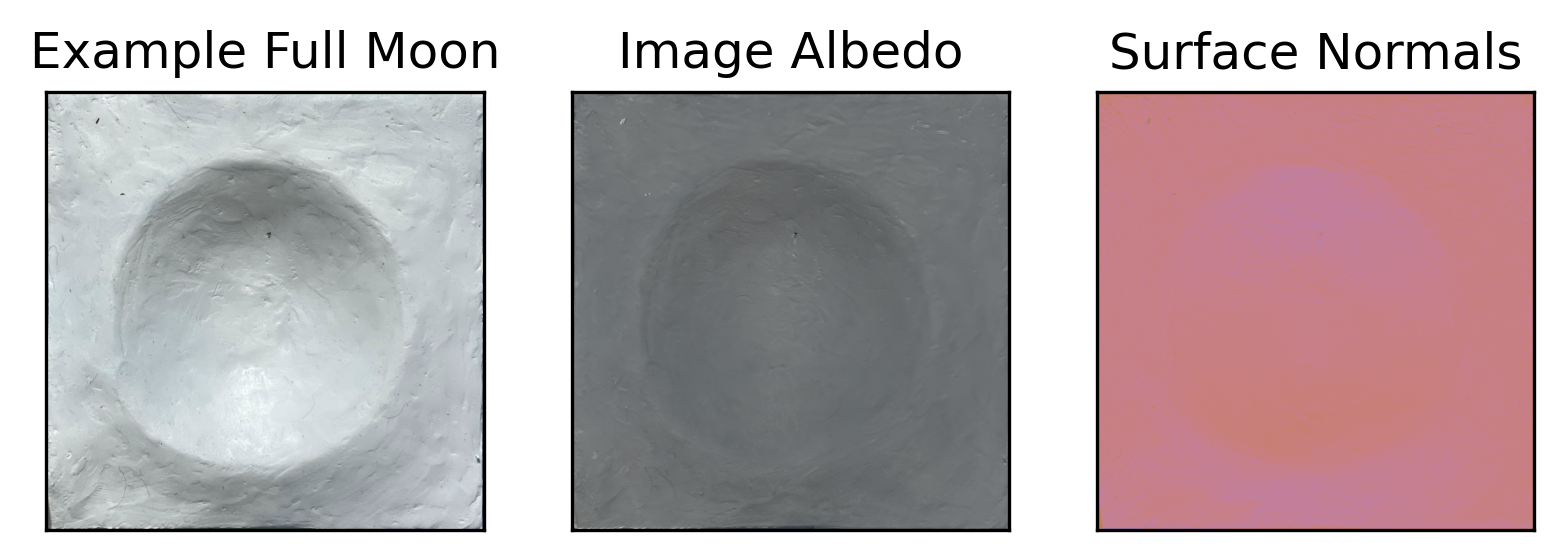

In [90]:
plt.figure()
plt.subplot(1,3,1)
example_img_index = 2
img = (imgs[example_img_index] - np.min(imgs[example_img_index])) / (np.max(imgs[example_img_index]) - np.min(imgs[example_img_index]))  #normalizing image between 0-1 for visualization
plt.imshow(img)
plt.title('Example Full Moon')
plt.xticks([])
plt.yticks([])
#plt.plot([1,2,3,4])
plt.subplot(1,3,2)
#plt.plot([1,2,3,4])
plt.imshow(img_albedo)
plt.title('Image Albedo')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
#plt.plot([1,2,3,4])
plt.imshow(img_normal_rgb)
plt.title('Surface Normals')
plt.xticks([])
plt.yticks([])
plt.show()

/opt/homebrew/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/opt/homebrew/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


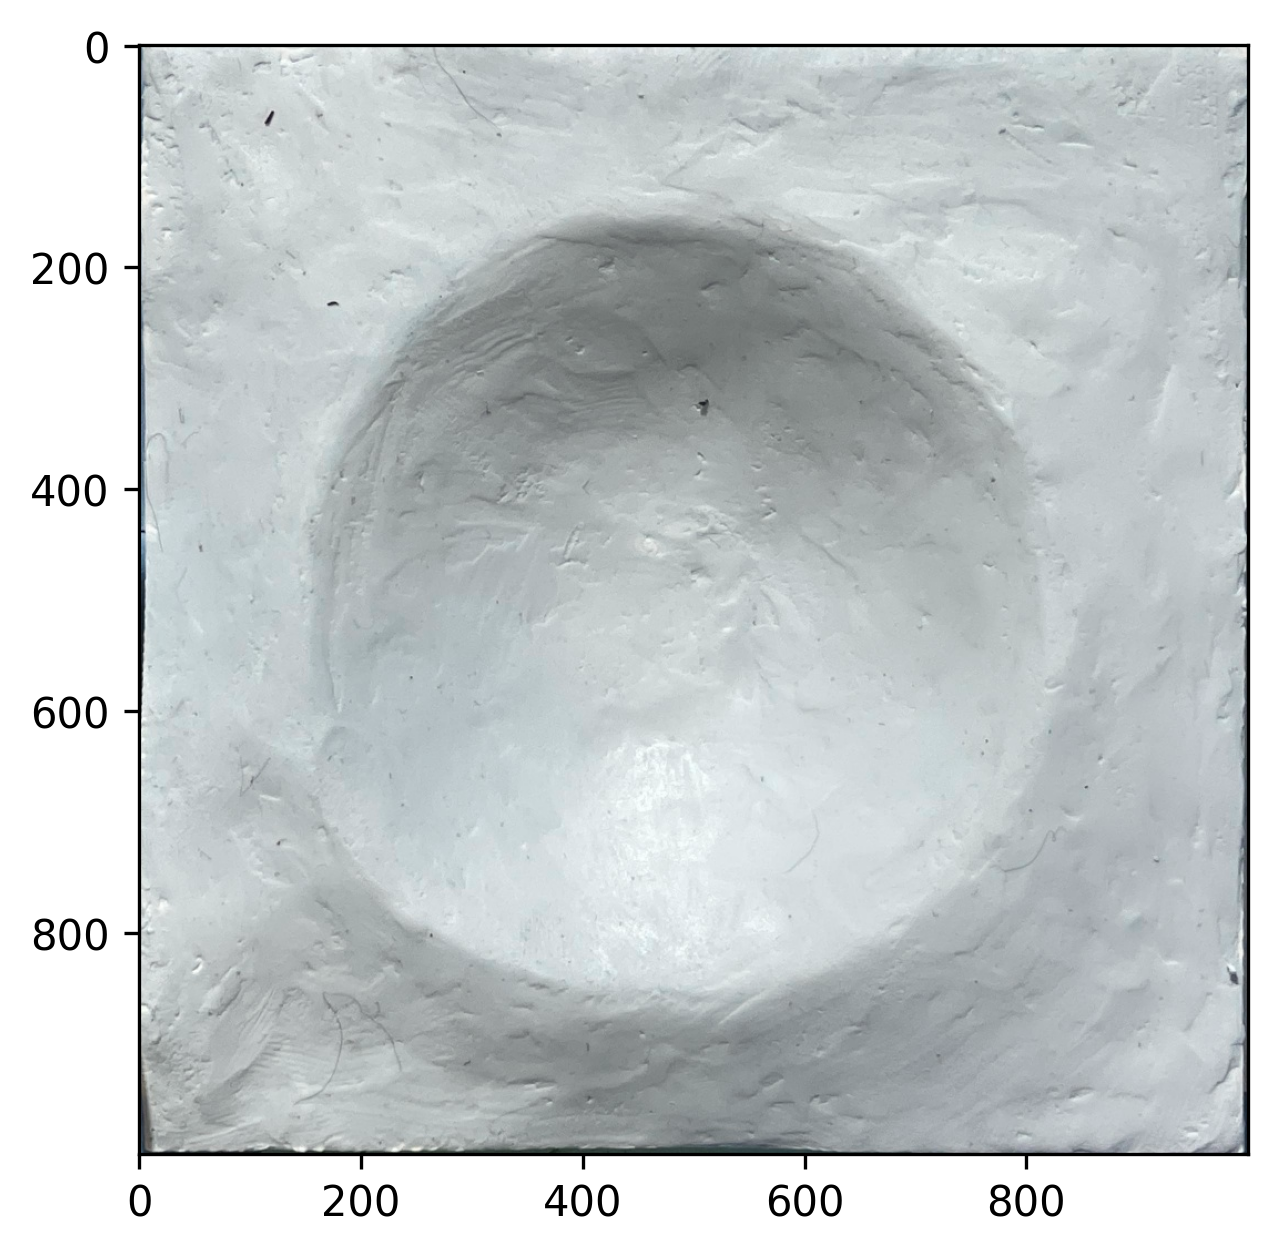

In [91]:
# Graph a new quiver plot with the normals
plt.figure()
plt.imshow(imgs[example_img_index])
# plt.quiver(normals[:,:,0], normals[:,:,1], normals[:,:,2])
x_pos = np.arange(0, normals.shape[0], 5)
y_pos = np.arange(0, normals.shape[1], 5)
plt.quiver(x_pos, y_pos, normals[x_pos, y_pos, 0], normals[x_pos, y_pos, 1])
plt.show()